# Generate Data

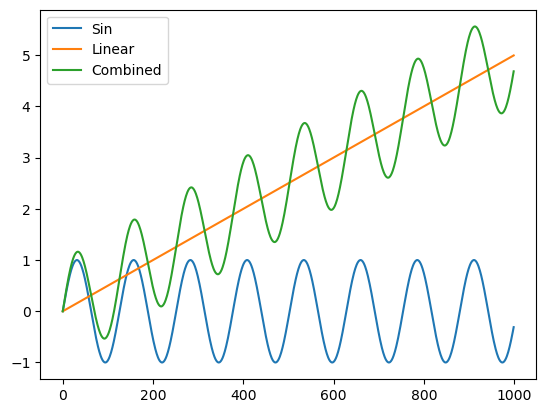

In [8]:
import numpy as np
import matplotlib.pyplot as plt

sin = np.sin(np.arange(1000)*.05)
linear = np.arange(1000)*.005
combined = sin + linear

plt.plot(sin, label='Sin')
plt.plot(linear, label='Linear')
plt.plot(combined, label='Combined')
plt.legend()
plt.show()



Exponential Smoothing:
$ S_t = \alpha y_t + (1 - \alpha) S_{t-1} $, where
- $ S_t $ is the smoothed value at time $ t $
- $ y_t $ is the actual value at time $ t $
- $ \alpha $ is the smoothing parameter, $ 0 \leq \alpha \leq 1 $


ARIMA
$ \phi(B)(1 - B)^d y_t = \theta(B) \varepsilon_t $, where
- $ p $ is the order of the autoregressive (AR) part
- $ d $ is the degree of differencing
- $ q $ is the order of the moving average (MA) part
- $ B $ is the backshift operator, $ B^k y_t = y_{t-k} $
- $ \phi(B) $ is the AR polynomial, $ \phi(B) = 1 - \phi_1 B - \phi_2 B^2 - \ldots - \phi_p B^p $
- $ \theta(B) $ is the MA polynomial, $ \theta(B) = 1 + \theta_1 B + \theta_2 B^2 + \ldots + \theta_q B^q $
- $ \varepsilon_t $ is the white noise error term at time $ t $


In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Fit Exponential Smoothing model
exp_model = SimpleExpSmoothing(combined).fit(smoothing_level=0.2, optimized=False)
exp_smoothing_forecast = exp_model.fittedvalues

# Fit ARIMA model
arima_model = ARIMA(combined, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.fittedvalues

# Plot original data and fitted values
plt.figure(figsize=(12, 6))
plt.plot(combined, label='Original Data')
plt.plot(exp_smoothing_forecast, label='Exponential Smoothing')
plt.plot(arima_forecast, label='ARIMA')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'statsmodels'

/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting paramet

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47275D+02    |proj g|=  6.12860D+07
  ys=-1.334E+00  -gs= 8.187E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -6.25389D+00    |proj g|=  3.11073D+02
  ys=-3.875E-05  -gs= 1.174E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -6.25834D+00    |proj g|=  1.11660D+02
  ys=-9.462E-07  -gs= 1.170E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12    133      4     3     0   1.367D+01  -6.258D+00
  F =  -6.2583402336756118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


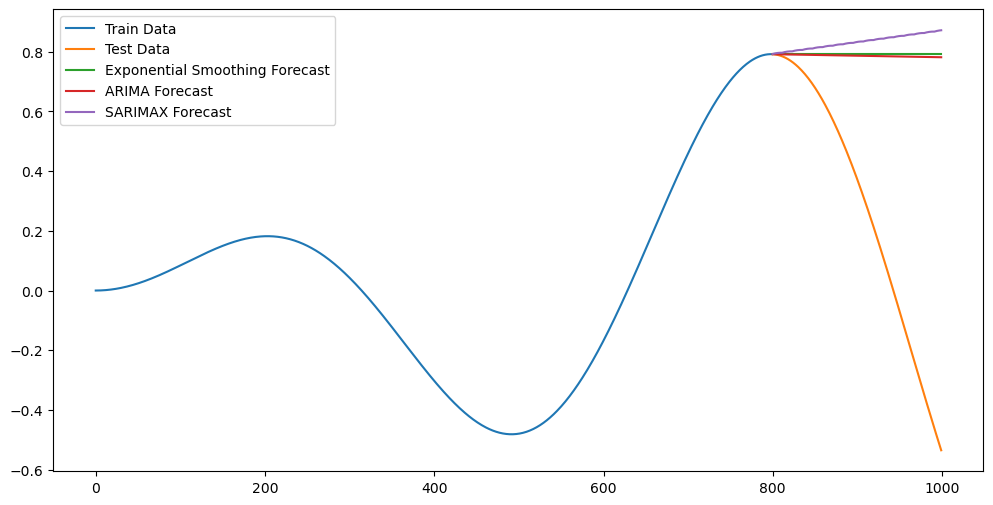

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split the data into train and test sets
train_size = int(len(combined) * 0.8)
train, test = combined[:train_size], combined[train_size:]

# Fit Exponential Smoothing model on train data
exp_model = SimpleExpSmoothing(train).fit(smoothing_level=0.2, optimized=False)
exp_smoothing_forecast = exp_model.forecast(len(test))

# Fit ARIMA model on train data with adjusted parameters
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(len(test))

# Fit SARIMAX model on train data
sarimax_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax_model.fit()
sarimax_forecast = sarimax_fit.forecast(len(test))

# Plot original train and test data, and forecasts
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')
plt.plot(np.arange(train_size, len(combined)), exp_smoothing_forecast, label='Exponential Smoothing Forecast')
plt.plot(np.arange(train_size, len(combined)), arima_forecast, label='ARIMA Forecast')
plt.plot(np.arange(train_size, len(combined)), sarimax_forecast, label='SARIMAX Forecast')
plt.legend()
plt.show()
